In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras.callbacks import Callback, LearningRateScheduler
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV

In [91]:
folder = "without_na"

train = pd.read_csv("{}/train_clean.csv".format(folder))
val = pd.read_csv("{}/validation_clean.csv".format(folder))

In [92]:
train.columns

Index(['objid', 'u_0', 'g_0', 'r_0', 'i_0', 'z_0', 'clean', 'rowc', 'colc',
       'rowv', 'colv', 'u_3', 'g_3', 'r_3', 'i_3', 'z_3', 'u_4', 'g_4', 'r_4',
       'i_4', 'z_4', 'u_5', 'g_5', 'r_5', 'i_5', 'z_5', 'u_6', 'g_6', 'r_6',
       'i_6', 'z_6', 'class', 'u_3_na', 'g_3_na', 'r_3_na', 'i_3_na', 'z_3_na',
       '0th_above', '3rd_above', '4th_above', '5th_above'],
      dtype='object')

In [93]:
# '-6' are categorical variables and need to be converted

features = ["{}_6".format(b) for b in ['u', 'g', 'r', 'i', 'z']]

dummy_train = pd.DataFrame()
dummy_val = pd.DataFrame()
for f in features:   
    dummy_train = pd.concat([dummy_train, pd.get_dummies(train[f], prefix=f)], axis=1)    
    dummy_val = pd.concat([dummy_val, pd.get_dummies(val[f], prefix=f)], axis=1)

# in case test set has values train set doesn't have
values = ["{}_{}".format(f, i) for f in features for i in range(9)]

dummy_train = dummy_train.reindex(columns=values).fillna(0).astype('int64')
dummy_val = dummy_val.reindex(columns=values).fillna(0).astype('int64')

train = pd.concat([train, dummy_train], axis=1)
val = pd.concat([val, dummy_val], axis=1)

# drop initial categorical variables
train.drop(features, axis=1, inplace=True)
val.drop(features, axis=1, inplace=True)

In [94]:
len(train.columns)

81

In [95]:
features_to_drop = ['objid', 'class']

X_train = train.drop(features_to_drop, axis=1).values
y_train = train['class'].values
y_train = to_categorical(y_train, num_classes=3)
    
X_test = val.drop(features_to_drop, axis=1).values
y_test = val['class'].values
y_test = to_categorical(y_test, num_classes=3)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)    

In [154]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 
    

In [155]:
def get_class_weights(labels):
    classes, class_counts = np.unique(labels, return_counts=True)
    weights = 1 - class_counts / np.sum(class_counts)
    return {c:w for c, w in zip(classes, weights)}

In [161]:
# update learning rate every 5 epochs
def get_lr(epoch):
    initial_lr = 0.003
    l_rate = initial_lr * np.power(0.5, epoch // 30)
    return l_rate
lrate = LearningRateScheduler(get_lr)

In [162]:
model = Sequential()

model.add(Dense(35, 
                input_dim=79, 
                activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(20, 
                activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, 
                activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

adam = Adam(lr=0.002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[f1])

history = model.fit(X_train, y_train,
                    epochs=75,
                    batch_size=1024,
                    validation_data=[X_test, y_test],
                    class_weight=get_class_weights(val['class']),
                    callbacks=[lrate]
                   )

Train on 30000 samples, validate on 23333 samples
Epoch 1/75
30000/30000 [==============================] - 3s 99us/step - loss: 0.6787 - f1: 0.2854 - val_loss: 0.8987 - val_f1: 0.5037
Epoch 2/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.5059 - f1: 0.6396 - val_loss: 0.6516 - val_f1: 0.7270
Epoch 3/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.4540 - f1: 0.7064 - val_loss: 0.6166 - val_f1: 0.7510
Epoch 4/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.4221 - f1: 0.7423 - val_loss: 0.5824 - val_f1: 0.7693
Epoch 5/75
30000/30000 [==============================] - 0s 11us/step - loss: 0.4024 - f1: 0.7615 - val_loss: 0.5579 - val_f1: 0.7806
Epoch 6/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.3889 - f1: 0.7731 - val_loss: 0.5493 - val_f1: 0.7902
Epoch 7/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.3795 - f1: 0.7816 - val_loss: 0.5300 - val_f1: 0.8019
Epoch

Epoch 61/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.2759 - f1: 0.8575 - val_loss: 0.3568 - val_f1: 0.8849
Epoch 62/75
30000/30000 [==============================] - 0s 11us/step - loss: 0.2753 - f1: 0.8573 - val_loss: 0.3584 - val_f1: 0.8851
Epoch 63/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.2754 - f1: 0.8582 - val_loss: 0.3575 - val_f1: 0.8852
Epoch 64/75
30000/30000 [==============================] - 0s 11us/step - loss: 0.2789 - f1: 0.8579 - val_loss: 0.3566 - val_f1: 0.8845
Epoch 65/75
30000/30000 [==============================] - 0s 11us/step - loss: 0.2740 - f1: 0.8591 - val_loss: 0.3575 - val_f1: 0.8847
Epoch 66/75
30000/30000 [==============================] - 0s 11us/step - loss: 0.2755 - f1: 0.8580 - val_loss: 0.3576 - val_f1: 0.8849
Epoch 67/75
30000/30000 [==============================] - 0s 12us/step - loss: 0.2743 - f1: 0.8594 - val_loss: 0.3572 - val_f1: 0.8855
Epoch 68/75
30000/30000 [=======================

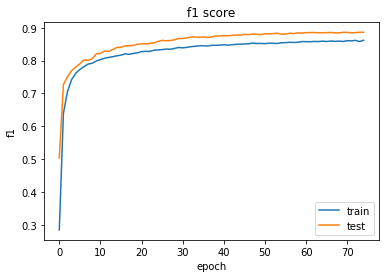

In [163]:
#loss: 0.2705 - f1: 0.8599 - val_loss: 0.3561 - val_f1: 0.8827
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.show()

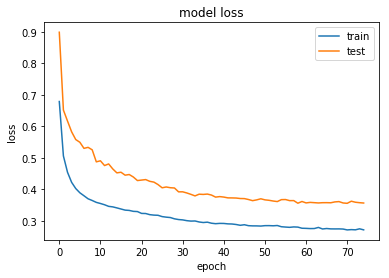

In [164]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [167]:
predictions_p = model.predict(X_test)
predictions = np.argmax(predictions_p, axis=1)
true_labels = np.argmax(y_test, axis=1)
f1_score(true_labels, predictions, average='macro')

0.8641384859999702

In [168]:
model.save("model_0_883.h5")

In [108]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=128,
                    validation_data=[X_test, y_test],
                    class_weight=get_class_weights(val['class']))

Train on 30000 samples, validate on 23333 samples
Epoch 1/3
30000/30000 [==============================] - 1s 25us/step - loss: 0.3173 - f1: 0.8322 - val_loss: 0.4027 - val_f1: 0.8650
Epoch 2/3
30000/30000 [==============================] - 1s 25us/step - loss: 0.3083 - f1: 0.8355 - val_loss: 0.3859 - val_f1: 0.8704
Epoch 3/3
30000/30000 [==============================] - 1s 25us/step - loss: 0.3052 - f1: 0.8378 - val_loss: 0.3768 - val_f1: 0.8738


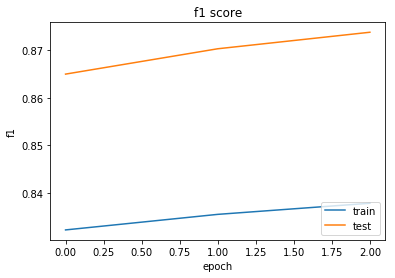

In [109]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.show()

In [110]:
predictions_p = model.predict(X_test)
predictions = np.argmax(predictions_p, axis=1)
true_labels = np.argmax(y_test, axis=1)
f1_score(true_labels, predictions, average='macro')

0.8537823752891854